# REINFORCE on Mountain Car

In [258]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import trange

plt.rcParams['text.usetex'] = True

## Defining the Environment

In [259]:
MIN_POSITION = -1.2
MAX_POSITION = 0.5
MIN_VELOCITY = -0.07
MAX_VELOCITY = 0.07
TIMEOUT      = 1000
DISCOUNT_RATE = 1.

In [260]:
class PolicyNet(nn.Module):
    """
    Policy neural network:
      - Inputs:   2 numbers corresponding to the current state [x, v]
      - Outputs:  3 score values ("preferences"), one per action: Pref^{Reverse}, Pref^{Neutral}, Pref^{Forward}
      - The 'act' method takes as input a state, computes the 3 scores values ("preferences") mentioned above, and
        transforms them into probabilities via a Softmax operation. It then returns a_t = -1.0 if the sampled action is Reverse,
        a_t = 0.0 is the sampled action is Neutral, and a_t = +1 if the sampled action is Forward.
    """

    def __init__(self, neurons_per_layer: list[int]):
        super().__init__()
        layers = []
        n_inputs  = 2 # Number of inputs  is 2 because the state is s=[x,v])
        n_outputs = 3 # Number of outputs is 3 because the network outputs one score value ("preference") for each action
        self.temperature = 2.

        last = n_inputs 
        for h in neurons_per_layer:
            layers.append(nn.Linear(last, h))
            layers.append(nn.Tanh())
            last = h
        layers.append(nn.Linear(last, n_outputs))
        self.net = nn.Sequential(*layers)
        
        # Precompute constants needed to later perform [-1, 1] normalization when given an unnormalized state s=[x,v] as input
        self.pos_mid  = 0.5 * (MIN_POSITION + MAX_POSITION)
        self.pos_half = 0.5 * (MAX_POSITION - MIN_POSITION)
        self.vel_mid  = 0.5 * (MIN_VELOCITY + MAX_VELOCITY)
        self.vel_half = 0.5 * (MAX_VELOCITY - MIN_VELOCITY)

    def _normalize(self, x: torch.Tensor) -> torch.Tensor:
        pos = x[..., 0]
        vel = x[..., 1]
        pos_n = (pos - self.pos_mid) / self.pos_half
        vel_n = (vel - self.vel_mid) / self.vel_half
        return torch.stack([pos_n, vel_n], dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_n = self._normalize(x)
        return self.net(x_n)

    @torch.no_grad()
    def act(self, state: torch.Tensor) -> torch.Tensor:
        x = state.unsqueeze(0)  # (1,2)
        logits = self.forward(x).squeeze(0)  # (3,)
        probs = F.softmax(logits / self.temperature, dim=-1)
        probs = torch.clip(probs, 1e-8, 1.0)
        probs = probs / probs.sum()
        action_idx = torch.multinomial(probs, num_samples=1).squeeze()
        return (action_idx - 1).to(torch.float32)

class ValueNet(nn.Module):
    def __init__(self, neurons_per_layer: list[int]) -> None:
        super().__init__()
        n_inputs  = 2 # Number of inputs  is 2 because the state is s=[x,v])
        n_outputs = 1 # Number of outputs is 1 because the network outputs the value 

        layers = []
        last = n_inputs 
        for h in neurons_per_layer:
            layers.append(nn.Linear(last, h))
            layers.append(nn.Tanh())
            last = h
        layers.append(nn.Linear(last, n_outputs))
        self.net = nn.Sequential(*layers)

        # Precompute constants needed to later perform [-1, 1] normalization when given an unnormalized state s=[x,v] as input
        self.pos_mid  = 0.5 * (MIN_POSITION + MAX_POSITION)
        self.pos_half = 0.5 * (MAX_POSITION - MIN_POSITION)
        self.vel_mid  = 0.5 * (MIN_VELOCITY + MAX_VELOCITY)
        self.vel_half = 0.5 * (MAX_VELOCITY - MIN_VELOCITY)

    def _normalize(self, x: torch.Tensor) -> torch.Tensor:
        pos = x[..., 0]
        vel = x[..., 1]
        pos_n = (pos - self.pos_mid) / self.pos_half
        vel_n = (vel - self.vel_mid) / self.vel_half
        return torch.stack([pos_n, vel_n], dim=-1)
    
    def forward(self, x: torch.Tensor):
        x = self._normalize(x)
        return self.net(x)

In [261]:
def generate_episode(policy: PolicyNet):
    x = torch.empty(1)
    x.uniform_(-0.6, -0.4)
    v = torch.zeros(1)

    steps: list[tuple[torch.Tensor, torch.Tensor, float]] = []

    for _ in range(TIMEOUT):
        state = torch.tensor([x, v])
        action = policy.act(state)
        v_new = v + 0.001 * action - 0.0025 * torch.cos(3 * x)
        x_new = x + v_new
        v_new = torch.clamp(v_new, MIN_VELOCITY, MAX_VELOCITY)
        x_new = torch.clamp(x_new, MIN_POSITION, MAX_POSITION)
        if x_new == MIN_POSITION or x_new == MAX_POSITION:
            v_new = 0

        if x_new == MAX_POSITION:
            steps.append((state, action, 0.))
            break
        else:
            steps.append((state, action, -1.))

        x = x_new
        v = v_new

    for i in range(len(steps)-1, 0, -1):
        s, a, r = steps[i-1]
        steps[i-1] = (s, a, r + DISCOUNT_RATE * steps[i][2])

    return steps

## REINFORCE Algorithm with Baseline
(Modified to incorporate Adam optimizer)

In [262]:
def reinforce_baseline(alpha_w: float, alpha_theta: float):
    policy_net = PolicyNet([8, 8])
    value_net = ValueNet([8, 8])
    returns: list[float] = []

    v_optim = torch.optim.Adam(value_net.parameters(), lr=alpha_w)
    p_optim = torch.optim.Adam(policy_net.parameters(), lr=alpha_theta)

    MAX_ITER = 1000
    for _ in trange(MAX_ITER):
        steps = generate_episode(policy_net)
        returns.append(steps[0][2])

        for t, (state, action, G) in enumerate(steps):
            value = value_net(state)
            delta = G - value
            value_loss = delta**2 / 2
            value_loss.backward()
            v_optim.step()
            v_optim.zero_grad()

            logits = policy_net(state)
            log_probs = F.log_softmax(logits / policy_net.temperature, dim=-1)
            log_prob = log_probs[action.int()+1]
            policy_loss = -log_prob * delta.detach() * DISCOUNT_RATE**t
            policy_loss.backward()
            p_optim.step()
            p_optim.zero_grad()

    return policy_net, value_net, returns

In [263]:
torch.manual_seed(0)

hyperparams = [
    (5e-4, 8e-4),
    (5e-4, 2e-3),
    (1e-3, 8e-4),
    (1e-3, 2e-3),
]
results = []

for alpha_w, alpha_theta in hyperparams:
    _, _, rs = reinforce_baseline(alpha_w=alpha_w, alpha_theta=alpha_theta)
    results.append(rs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:53<00:00,  4.29it/s]


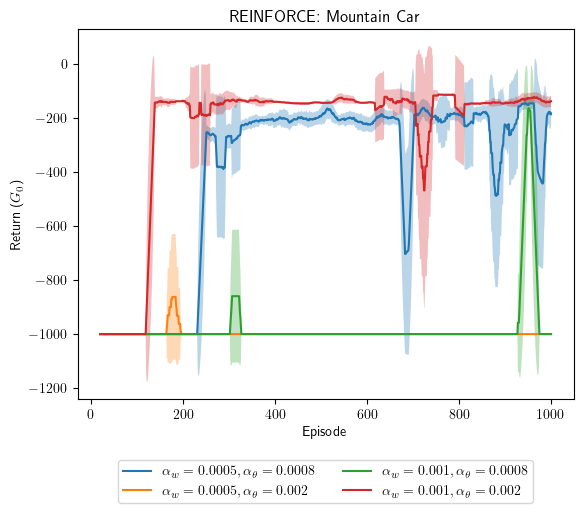

In [264]:
for (alpha_w, alpha_theta), rs in zip(hyperparams, results):
    returns = np.array(rs)
    window = 20
    
    means = np.convolve(returns, np.ones(window)/window, mode='valid')
    stds = np.array([returns[i-window:i].std() for i in range(window, len(returns)+1)])
    episodes = np.arange(window, len(returns)+1)
    
    plt.plot(episodes, means, label=f"$\\alpha_w = {alpha_w}, \\alpha_\\theta = {alpha_theta}$")
    plt.fill_between(episodes, means-stds, means+stds, alpha=0.3)

plt.xlabel("Episode")
plt.ylabel("Return ($G_0$)")
plt.title("REINFORCE: Mountain Car")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.savefig("plot-mountaincar.png", dpi=300, bbox_inches='tight')
plt.show()